<a href="https://colab.research.google.com/github/Legacy560/MTLSA25-Sales-Forecasting-Project/blob/main/Cleaning%20and%20ARIMA/PHYS_664_Project_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as pl
import json
import os
import warnings
import dask.dataframe as dd
from statsmodels.tsa.stattools import adfuller
# import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
import time
import math
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/Shareddrives/MLTSA25-Sales-Forecasting/Project

/content/gdrive/Shareddrives/MLTSA25-Sales-Forecasting/Project


In [4]:
cal = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')
salesVal = pd.read_csv('sales_train_validation.csv')
display(cal.head())
display(salesVal.head())
display(prices.head())

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [5]:
#This code came from: https://www.kaggle.com/competitions/m5-forecasting-accuracy/data. I take no credit for it.

#Downcast in order to save memory
def downcast(df):

  '''
  Changes column types in the dataframe to reduce memory usage.
  Input:
    df (pandas dataframe): dataframe to be downcast.
  Output:
    df (pandas dataframe): dataframe with reduced memory usage.
  '''
  cols = df.dtypes.index.tolist()
  types = df.dtypes.values.tolist()
  for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
  return df

salesVal = downcast(salesVal)
prices = downcast(prices)
cal = downcast(cal)


In [6]:
salesValLong = salesVal.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                         var_name="d", value_name="units_sold").dropna()
#This gives us a column "d" containing each sales day. This is the same as the "d" column from calendar

In [7]:
#Merge with Calendar dataset
salesValLong1 = salesValLong.merge(cal, on="d", how="left")
#Merge with prices dataset
salesFull = salesValLong1.merge(prices, on=["store_id", "item_id", "wm_yr_wk"], how="left")

display(salesValLong1.head())

,id,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [8]:
#dump the previous datasets
del salesValLong
del cal
del prices
del salesVal
del salesValLong1


In [9]:
# Step 1: Filter for a single store: CA_1
df_CA_1 = salesFull[salesFull['store_id'] == 'CA_1']

# Step 2: Get unique item IDs sold at this store
unique_items = df_CA_1['item_id'].unique()

# Step 3: Randomly choose 10 items (fixed seed)
np.random.seed(42)
selected_items = np.random.choice(unique_items, size=10, replace=False)

# Step 4: Filter the full store dataset for those 10 items
subset_df_CA_1 = df_CA_1[df_CA_1['item_id'].isin(selected_items)].copy()


In [10]:
del salesFull

In [11]:
# Ensure the date column is in datetime format
subset_df_CA_1['date'] = pd.to_datetime(subset_df_CA_1['date'])

# Extract day of week (0=Monday,...,6=Sunday) and month
subset_df_CA_1['day_of_week'] = subset_df_CA_1['date'].dt.dayofweek
subset_df_CA_1['month'] = subset_df_CA_1['date'].dt.month

# Flag weekends (Saturday=5, Sunday=6)
subset_df_CA_1['is_weekend'] = subset_df_CA_1['day_of_week'].isin([5, 6]).astype(int)

# Flag holidays: if the dataset has event/holiday info, use it; otherwise use a predefined list or leave as 0
if 'event_name_1' in subset_df_CA_1.columns:
    # Mark a day as holiday if any event is present (from M5 dataset's event columns)
    subset_df_CA_1['is_holiday'] = subset_df_CA_1[['event_name_1', 'event_name_2']].notna().any(axis=1).astype(int)
else:
    subset_df_CA_1['is_holiday'] = 0  # (Replace with actual holiday logic if available)

# Sort by item ID and date to ensure chronological order per product
subset_df_CA_1 = subset_df_CA_1.sort_values(['id', 'date']).reset_index(drop=True)

# Inspect the DataFrame to verify new features (optional)
display(subset_df_CA_1[['d', 'date', 'units_sold', 'day_of_week', 'month', 'is_weekend', 'is_holiday']].head(10))


,d,date,units_sold,day_of_week,month,is_weekend,is_holiday
0,d_1,2011-01-29,1,5,1,1,0
1,d_2,2011-01-30,3,6,1,1,0
2,d_3,2011-01-31,0,0,1,0,0
3,d_4,2011-02-01,0,1,2,0,0
4,d_5,2011-02-02,2,2,2,0,0
5,d_6,2011-02-03,0,3,2,0,0
6,d_7,2011-02-04,0,4,2,0,0
7,d_8,2011-02-05,3,5,2,1,0
8,d_9,2011-02-06,5,6,2,1,1
9,d_10,2011-02-07,0,0,2,0,0


In [12]:
univariate_df_CA_1 = subset_df_CA_1[['id', 'units_sold']].copy()
display(univariate_df_CA_1.head())
display(univariate_df_CA_1.tail())

,id,units_sold
0,FOODS_2_135_CA_1_validation,1
1,FOODS_2_135_CA_1_validation,3
2,FOODS_2_135_CA_1_validation,0
3,FOODS_2_135_CA_1_validation,0
4,FOODS_2_135_CA_1_validation,2


,id,units_sold
19125,HOUSEHOLD_2_422_CA_1_validation,0
19126,HOUSEHOLD_2_422_CA_1_validation,0
19127,HOUSEHOLD_2_422_CA_1_validation,1
19128,HOUSEHOLD_2_422_CA_1_validation,0
19129,HOUSEHOLD_2_422_CA_1_validation,0


In [13]:
# Step 1: Sort by 'd' to ensure order
subset_df_CA_1 = subset_df_CA_1.sort_values('d').reset_index(drop=True)

# Step 2: Extract the list of item IDs (order is important!)
item_ids = subset_df_CA_1['id'].unique()

# Step 3: Create a dictionary to hold time series per item
ts_dict = {}

for i, item_id in enumerate(item_ids):
    ts = subset_df_CA_1.iloc[i::len(item_ids)]['units_sold'].values  # every 10th row starting at i
    ts_dict[item_id] = ts

# Step 4: Convert to DataFrame for wide format (items as rows, time as columns)
import pandas as pd

wide_df = pd.DataFrame(ts_dict).T  # transpose to get [item x time]
wide_df.columns = [f'd_{i+1}' for i in range(wide_df.shape[1])]

display(wide_df)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
FOODS_2_135_CA_1_validation,1,0,0,1,1,0,0,1,0,0,...,0,0,0,1,0,3,1,1,0,2
FOODS_2_257_CA_1_validation,0,1,0,1,0,0,0,0,0,0,...,0,2,2,3,0,2,4,0,2,2
HOBBIES_1_352_CA_1_validation,0,0,0,0,1,0,0,0,1,0,...,0,0,3,0,1,0,0,0,0,2
HOUSEHOLD_1_472_CA_1_validation,0,0,0,0,2,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
HOUSEHOLD_2_422_CA_1_validation,0,0,1,0,5,2,0,0,0,0,...,1,0,0,2,0,0,1,5,0,0
FOODS_3_145_CA_1_validation,0,0,3,0,0,0,4,0,1,1,...,0,0,1,2,0,0,0,0,0,0
HOUSEHOLD_2_349_CA_1_validation,0,0,2,0,5,5,0,0,0,0,...,0,6,0,0,0,2,3,2,0,0
FOODS_3_439_CA_1_validation,0,1,0,1,0,0,2,1,0,0,...,3,0,0,0,0,0,1,0,0,0
FOODS_3_452_CA_1_validation,1,0,2,0,0,0,1,2,0,0,...,0,3,0,1,0,0,0,1,0,0
HOUSEHOLD_2_077_CA_1_validation,0,0,0,0,0,4,1,0,1,0,...,2,1,0,0,2,0,0,0,0,0


In [14]:
def create_inout_sequences(input_data, input_window, output_window):
    """
    Generate input-output sequence pairs from a 1D time series for sequence-to-sequence learning.

    This function is typically used for preparing training data for time series forecasting models
    such as RNNs, LSTMs, GRUs, or Transformers. For each valid position in the input data, it extracts:

    - An input sequence of length `input_window`
    - A target (label) sequence of length `input_window`, starting `output_window` steps ahead

    Parameters
    ----------
    input_data : array-like (e.g., list, np.ndarray, or torch.Tensor)
        A 1D array containing the full time series data from which sequences will be extracted.
    input_window : int
        The number of time steps in each input sequence.
    output_window : int
        The time lag before prediction begins. The output (target) sequence begins after this lag,
        and is of the same length as the input sequence.

    Returns
    -------
    torch.FloatTensor
        A tensor of shape (num_sequences, 2, input_window) where each element is a pair:
        (input_sequence, output_sequence). The output_sequence is taken `output_window` steps
        ahead of the input_sequence.

    Example usage
    -------
    >>> data = np.arange(20)
    >>> sequences = create_inout_sequences(data, input_window=5, output_window=2)
    >>> sequences.shape
    torch.Size([14, 2, 5])
    """
    inout_seq = []
    L = len(input_data)
    block_num =  L - block_len + 1
    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq))


In [15]:
def get_data(data, input_window, standardization=None):
    """
    Prepares training and testing sequences from a 1D time series array.

    Parameters:
    -----------
    data : np.ndarray
        1D NumPy array of time series data.
    input_window : int
        Length of the input sequence for the model.
    standardization : str or None, optional
        Type of scaling to apply to the data.
        Can be 'standard', 'minmax', or None.

    Returns:
    --------
    train_sequence : torch.Tensor
        Training data (input, target) tuples.
    test_data : torch.Tensor
        Testing data (input, target) tuples.
    unique_vals : np.ndarray
        Sorted array of unique scaled values in the dataset.
    weights_tensor : torch.Tensor
        Class weights tensor for CrossEntropyLoss (normalized inverse class frequency).
    """
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    if standardization == 'standard':
        scaler = StandardScaler()
    elif standardization == 'minmax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
    else:
        scaler = None

    if scaler is not None:
        data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

    unique_vals = np.sort(np.unique(data))

    samples = len(data) - input_window - 1
    train_data = data[:samples]
    test_data = data[samples:]

    train_sequence = create_inout_sequences(train_data, input_window, output_window)
    test_data = create_inout_sequences(test_data, input_window, output_window)

    # Flatten all target labels
    all_targets_tensor = torch.cat([y.view(-1) for _, y in train_sequence], dim=0)
    all_targets_np = all_targets_tensor.cpu().numpy()

    # Count frequencies using a loop over unique_vals
    class_counts = []
    for val in unique_vals:
        count = np.sum(all_targets_np == val)
        class_counts.append(count)

    # Count how often each unique value appears in the (scaled) input data
    class_counts = [np.sum(data == x) for x in unique_vals]
    inverse_freq = 1.0 / np.array(class_counts)
    weights = inverse_freq / inverse_freq.sum()
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

    print(train_sequence.shape)
    print(test_data.shape)
    print(unique_vals.shape)
    print(weights_tensor.shape)

    return train_sequence.to(device), test_data.to(device), unique_vals, weights_tensor


In [16]:
def get_batch(input_data, i, batch_size):
    """
    Extracts a batch of input-target sequence pairs from preprocessed data for training.

    This function slices the dataset (typically generated using `create_inout_sequences`)
    and formats it into the shape expected by Transformer models:
    (sequence_length, batch_size, feature_dimension), where the feature dimension is 1
    for univariate time series.

    Parameters
    ----------
    input_data : list of tuples
        The dataset containing (input_sequence, target_sequence) pairs.
        Each pair is assumed to be of shape (input_window,).
    i : int
        Starting index in `input_data` from which to extract the batch.
    batch_size : int
        The number of samples to include in the batch.

    Returns
    -------
    input : torch.Tensor of shape (input_window, batch_len, 1)
        A tensor containing the input sequences for the batch.
    target : torch.Tensor of shape (input_window, batch_len, 1)
        A tensor containing the target sequences for the batch.

    Notes
    -----
    - If there are fewer than `batch_size` samples remaining at the end of the dataset,
      the batch is truncated to avoid index errors.
    - This function assumes that the inputs and targets are already prepared with consistent lengths.

    Example
    -------
    >>> batch_input, batch_target = get_batch(train_data, i=0, batch_size=16)
    >>> batch_input.shape
    torch.Size([input_window, 16, 1])
    """
    batch_len = np.min((batch_size, len(input_data) - i))
    data = input_data[i : i + batch_len]
    input = torch.stack([item[0] for item in data]).view((input_window, batch_len, 1))
    target = torch.stack([item[1] for item in data]).view((input_window, batch_len, 1))
    return input, target


In [17]:
torch.manual_seed(42)
input_window = 100 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = wide_df.iloc[0]
data = np.array(data)
block_len = input_window + output_window
train_data, val_data, unique_vals, weights_tensor = get_data(data, input_window=input_window, standardization='standard')


torch.Size([1712, 2, 100])
torch.Size([1, 2, 100])
(12,)
torch.Size([12])


#  Transformer autoregressive version

In [18]:
class PositionalEncoding(nn.Module):
    """
    Implements sinusoidal positional encoding for time-step information in sequence modeling.

    Args:
        d_model (int): Dimensionality of the embeddings.
        dropout (float): Dropout rate applied after adding positional encodings.
        max_len (int): Maximum sequence length for which encoding is computed.
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # shape: (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        pe = pe.unsqueeze(1)  # shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Adds positional encoding to the input embeddings.

        Args:
            x (Tensor): Input tensor of shape (seq_len, batch_size, d_model).

        Returns:
            Tensor: Positionally encoded input of the same shape as input.
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [19]:
class TransAm(nn.Module):
    """
    Transformer-based model for time series regression or sequence prediction.

    Architecture:
        - Input projection: Maps 1D input to `feature_size` dimensional embedding.
        - Positional encoding: Adds time-step information to embeddings.
        - Transformer encoder: Captures temporal dependencies.
        - Layer normalization: Stabilizes training.
        - Decoder (MLP): Maps encoded features to scalar predictions.

    Args:
        feature_size (int): Dimensionality of the embedding/hidden layers.
        num_layers (int): Number of transformer encoder layers.
        dropout (float): Dropout rate for regularization.
    """
    def __init__(self, feature_size=250, num_layers=2, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.feature_size = feature_size

        # Learnable input projection from scalar to feature_size
        self.input_projection = nn.Linear(1, feature_size)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(feature_size, dropout)

        # Transformer Encoder Stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size,
            nhead=10,
            dropout=dropout,
            batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Layer normalization
        self.norm = nn.LayerNorm(feature_size)

        # MLP decoder
        self.decoder = nn.Sequential(
            nn.Linear(feature_size, feature_size // 2),
            nn.ReLU(),
            nn.Linear(feature_size // 2, 1)
        )

        self.init_weights()

    def init_weights(self):
        """
        Initializes weights of all linear layers uniformly in [-0.1, 0.1].
        """
        initrange = 0.1
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.uniform_(-initrange, initrange)
                m.bias.data.zero_()

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the TransAm model.

        Args:
            src (Tensor): Input tensor of shape (seq_len, batch_size, 1), representing a sequence
                          of scalar time series values.

        Returns:
            Tensor: Output tensor of shape (seq_len, batch_size, 1), representing the predicted values.
        """
        src = self.input_projection(src)        # Shape: (seq_len, batch_size, feature_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.norm(output)
        output = self.decoder(output)           # Shape: (seq_len, batch_size, 1)
        return output


In [20]:
def train(train_data):
    """
    Runs one epoch of training for the Transformer model on the given time series dataset.

    This function processes the training data in mini-batches, computes predictions,
    evaluates the loss, performs backpropagation, and updates model weights. It also
    applies gradient clipping to ensure training stability and logs key training metrics.

    Parameters
    ----------
    train_data : list of tuples
        A list of (input_sequence, target_sequence) pairs, typically created using
        `create_inout_sequences`.

    Assumes the following global variables are defined:
    -----------------------------------------------
    model : nn.Module
        The Transformer model to be trained.
    optimizer : torch.optim.Optimizer
        The optimizer used for parameter updates.
    criterion : callable
        The loss function used to compute error between output and target (e.g., nn.MSELoss()).
    batch_size : int
        Number of samples in each mini-batch.
    input_window : int
        Length of input sequence for each sample (used in `get_batch`).
    epoch : int
        Current epoch number (used in logging output).
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler with `get_lr()` method.
    time : module
        Python's `time` module (for timing).
    math : module
        Python's `math` module (for computing perplexity via `math.exp()`).

    Prints
    ------
    Training statistics every ~20% of the epoch:
    - Current epoch and batch index
    - Learning rate
    - Elapsed time per logging interval (ms)
    - Average loss
    - Perplexity (exp of average loss)

    Returns
    -------
    float
        The average loss for the epoch.
    """
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    start_time = time.time()
    losses = []
    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()
        # scheduler.step()
        total_loss += loss.item()

        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            losses.append(total_loss / log_interval)
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

    return np.mean(losses)


In [21]:
def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)

    #test_result = test_result.cpu().numpy() -> no need to detach stuff..
    len(test_result)

    return total_loss / data_source.shape[0]


In [46]:
def predict_future(eval_model, data_source, true_data, steps):
    eval_model.eval()

    data, _ = get_batch(data_source , 0 , 1)
    true_data, _ = get_batch(true_data , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]

    data = data.cpu().view(-1)
    true_data = true_data.cpu().view(-1)
    data = data.cpu().view(-1)
    plt.figure(figsize=(16, 6))
    plt.plot(range(1914-input_window-steps,1914),data,color="blue", label = 'Forecast')
    plt.plot(range(1914-input_window-steps, 1914-steps),data[:input_window],color="red", label = 'Training data')
    plt.plot(range(1914-steps,1914),true_data[-steps:],color="green", label = 'True data')
    plt.grid(True, which='both')
    plt.xlabel("Day")
    plt.ylabel("Units sold(standardized)")
    plt.title("Sales forecast")
    plt.legend()
    plt.show()
    plt.close()


In [23]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1, eval_batch_size): # Now len-1 is not necessary
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [25]:
model = TransAm(feature_size=500, num_layers=3, dropout=0.1).to(device)

In [29]:
criterion = nn.MSELoss()
lr = 0.0001
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

In [27]:
extracted_part = train_data[-len(val_data):]
extracted_batch, extracted_target = get_batch(extracted_part, 0, 1)
print(model(extracted_batch[-input_window:]).shape)


torch.Size([100, 1, 1])


| epoch   1 |     5/   26 batches | lr 0.000100 | 10628.74 ms | loss 1.70997 | ppl     5.53
| epoch   1 |    10/   26 batches | lr 0.000100 | 8673.14 ms | loss 1.61236 | ppl     5.01
| epoch   1 |    15/   26 batches | lr 0.000100 | 8625.88 ms | loss 1.31945 | ppl     3.74
| epoch   1 |    20/   26 batches | lr 0.000100 | 8547.44 ms | loss 0.45804 | ppl     1.58
| epoch   1 |    25/   26 batches | lr 0.000100 | 8979.84 ms | loss 0.41323 | ppl     1.51


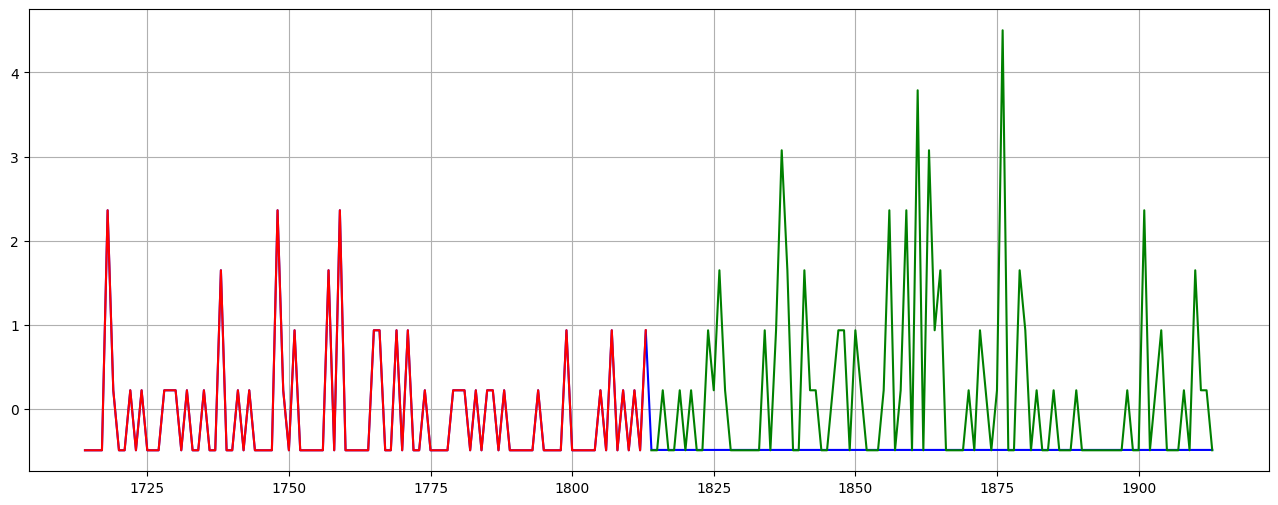

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 239.16s | valid loss 1.5344 | valid ppl     4.64
-----------------------------------------------------------------------------------------
| epoch   2 |     5/   26 batches | lr 0.000100 | 10341.60 ms | loss 1.87000 | ppl     6.49
| epoch   2 |    10/   26 batches | lr 0.000100 | 8531.96 ms | loss 1.59539 | ppl     4.93
| epoch   2 |    15/   26 batches | lr 0.000100 | 8671.38 ms | loss 1.36915 | ppl     3.93
| epoch   2 |    20/   26 batches | lr 0.000100 | 8651.91 ms | loss 0.44496 | ppl     1.56
| epoch   2 |    25/   26 batches | lr 0.000100 | 9024.69 ms | loss 0.40620 | ppl     1.50


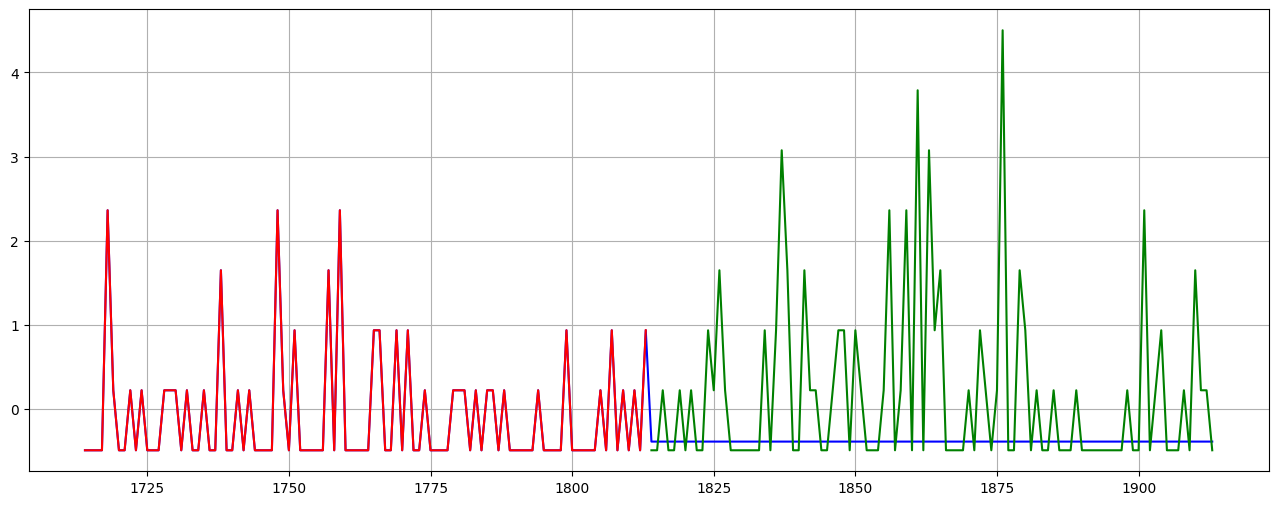

-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 236.50s | valid loss 1.4079 | valid ppl     4.09
-----------------------------------------------------------------------------------------
| epoch   3 |     5/   26 batches | lr 0.000100 | 10529.81 ms | loss 1.86836 | ppl     6.48
| epoch   3 |    10/   26 batches | lr 0.000100 | 8584.60 ms | loss 1.66228 | ppl     5.27
| epoch   3 |    15/   26 batches | lr 0.000100 | 8500.43 ms | loss 1.30318 | ppl     3.68
| epoch   3 |    20/   26 batches | lr 0.000100 | 8857.59 ms | loss 0.54615 | ppl     1.73
| epoch   3 |    25/   26 batches | lr 0.000100 | 8544.10 ms | loss 0.48188 | ppl     1.62


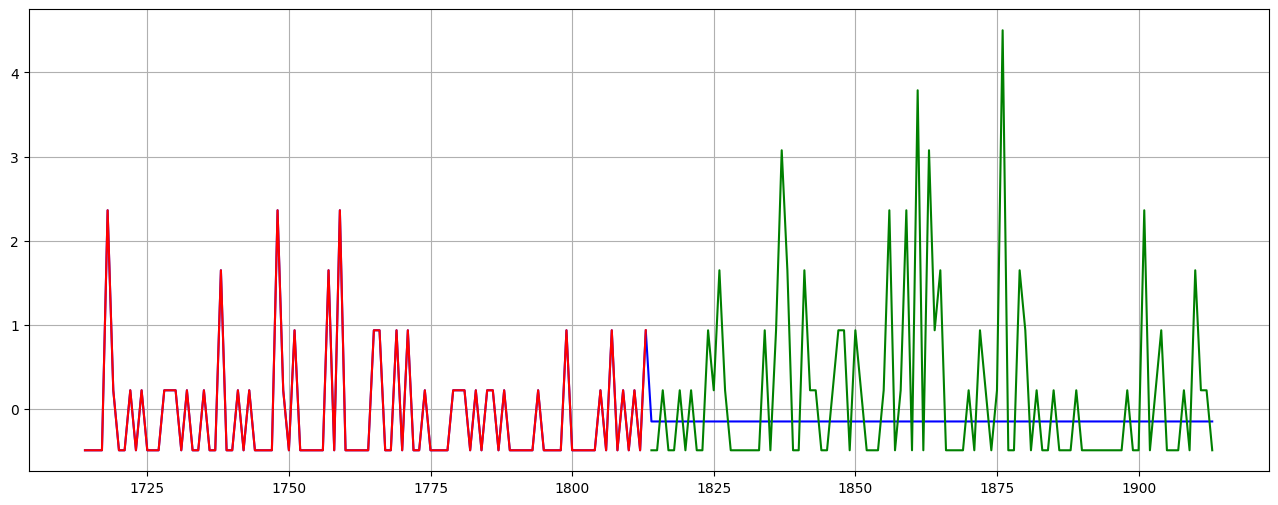

-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 236.73s | valid loss 1.1837 | valid ppl     3.27
-----------------------------------------------------------------------------------------
| epoch   4 |     5/   26 batches | lr 0.000100 | 10272.94 ms | loss 1.75161 | ppl     5.76
| epoch   4 |    10/   26 batches | lr 0.000100 | 8691.41 ms | loss 1.70401 | ppl     5.50
| epoch   4 |    15/   26 batches | lr 0.000100 | 8599.48 ms | loss 1.28126 | ppl     3.60
| epoch   4 |    20/   26 batches | lr 0.000100 | 8649.48 ms | loss 0.39539 | ppl     1.48
| epoch   4 |    25/   26 batches | lr 0.000100 | 8694.40 ms | loss 0.47482 | ppl     1.61


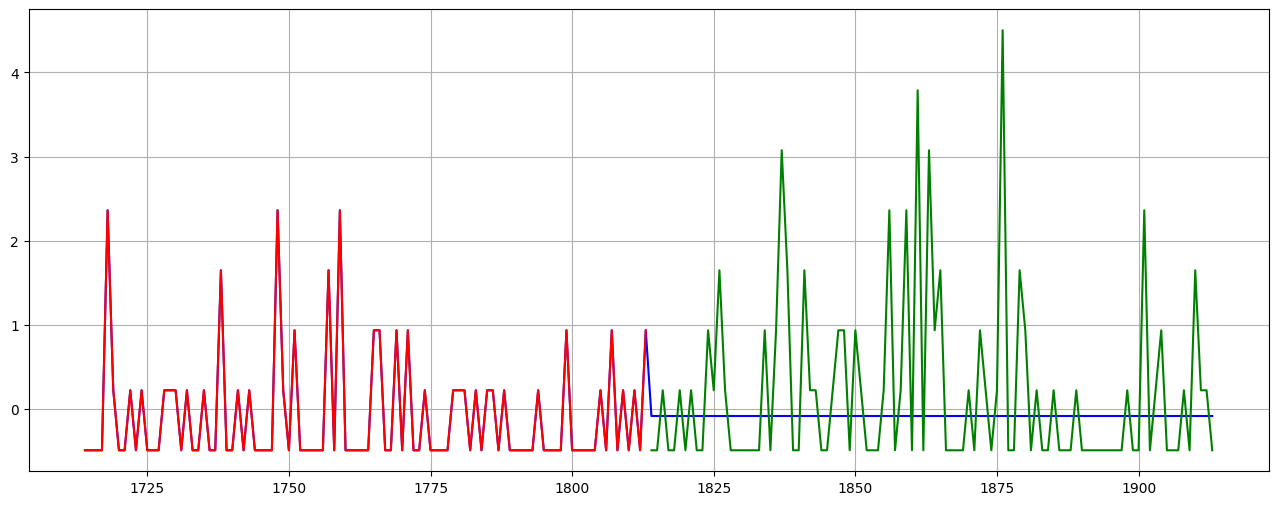

-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 235.86s | valid loss 1.1427 | valid ppl     3.14
-----------------------------------------------------------------------------------------
| epoch   5 |     5/   26 batches | lr 0.000100 | 10433.64 ms | loss 1.70578 | ppl     5.51
| epoch   5 |    10/   26 batches | lr 0.000100 | 8610.52 ms | loss 1.67607 | ppl     5.34
| epoch   5 |    15/   26 batches | lr 0.000100 | 8914.47 ms | loss 1.27816 | ppl     3.59
| epoch   5 |    20/   26 batches | lr 0.000100 | 8619.79 ms | loss 0.37883 | ppl     1.46
| epoch   5 |    25/   26 batches | lr 0.000100 | 8619.01 ms | loss 0.46763 | ppl     1.60


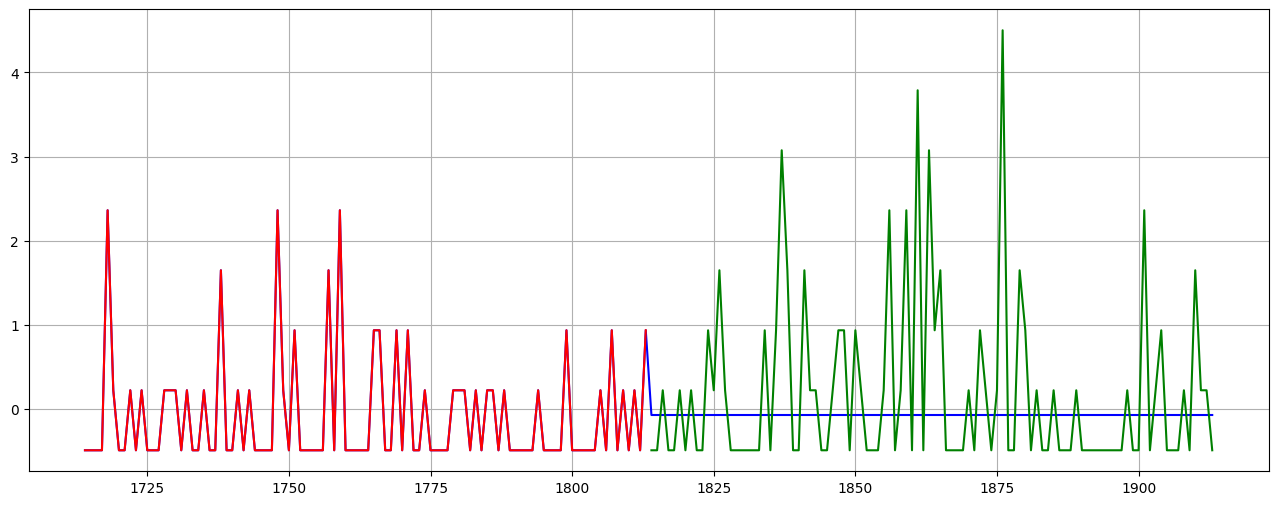

-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 237.55s | valid loss 1.1360 | valid ppl     3.11
-----------------------------------------------------------------------------------------
| epoch   6 |     5/   26 batches | lr 0.000100 | 10130.49 ms | loss 1.69963 | ppl     5.47
| epoch   6 |    10/   26 batches | lr 0.000100 | 9035.87 ms | loss 1.67247 | ppl     5.33
| epoch   6 |    15/   26 batches | lr 0.000100 | 8452.56 ms | loss 1.27790 | ppl     3.59
| epoch   6 |    20/   26 batches | lr 0.000100 | 8479.10 ms | loss 0.36941 | ppl     1.45
| epoch   6 |    25/   26 batches | lr 0.000100 | 8532.93 ms | loss 0.46388 | ppl     1.59


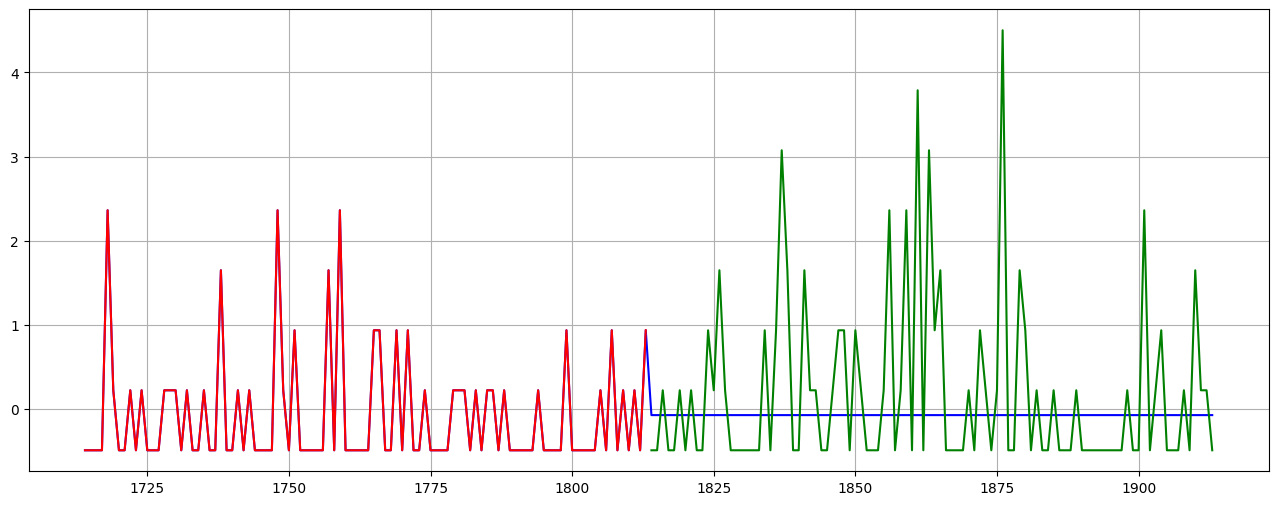

-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 235.06s | valid loss 1.1367 | valid ppl     3.12
-----------------------------------------------------------------------------------------
| epoch   7 |     5/   26 batches | lr 0.000100 | 10538.21 ms | loss 1.69777 | ppl     5.46
| epoch   7 |    10/   26 batches | lr 0.000100 | 9096.34 ms | loss 1.66843 | ppl     5.30
| epoch   7 |    15/   26 batches | lr 0.000100 | 8709.67 ms | loss 1.27794 | ppl     3.59
| epoch   7 |    20/   26 batches | lr 0.000100 | 8575.84 ms | loss 0.36787 | ppl     1.44
| epoch   7 |    25/   26 batches | lr 0.000100 | 8613.55 ms | loss 0.46284 | ppl     1.59


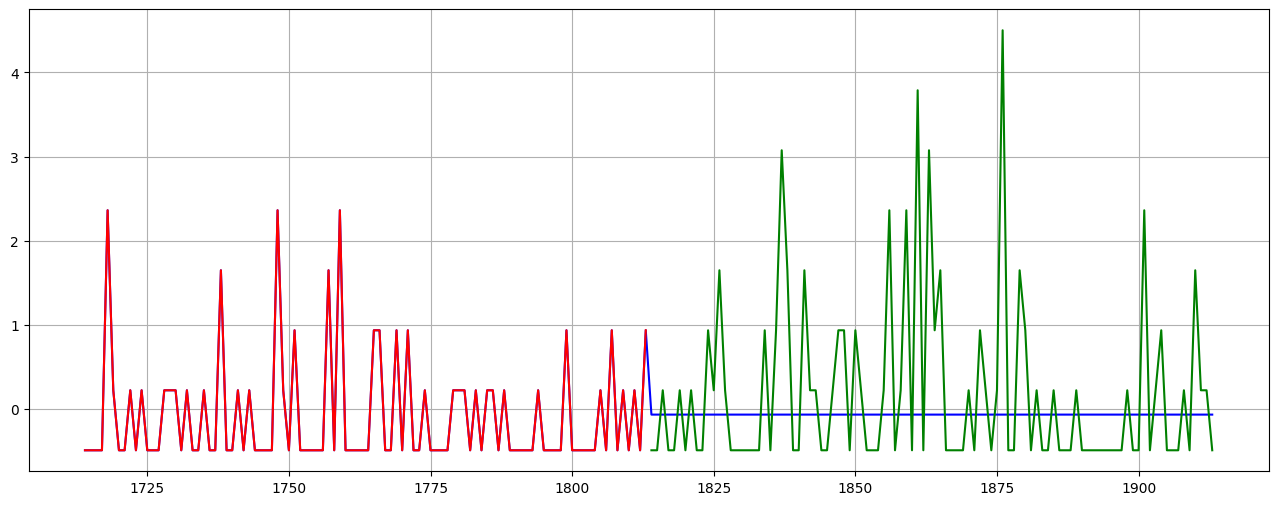

-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 239.40s | valid loss 1.1334 | valid ppl     3.11
-----------------------------------------------------------------------------------------
| epoch   8 |     5/   26 batches | lr 0.000100 | 10518.49 ms | loss 1.69565 | ppl     5.45
| epoch   8 |    10/   26 batches | lr 0.000100 | 8769.20 ms | loss 1.66759 | ppl     5.30
| epoch   8 |    15/   26 batches | lr 0.000100 | 8820.83 ms | loss 1.27750 | ppl     3.59
| epoch   8 |    20/   26 batches | lr 0.000100 | 8710.08 ms | loss 0.36514 | ppl     1.44
| epoch   8 |    25/   26 batches | lr 0.000100 | 8924.30 ms | loss 0.46258 | ppl     1.59


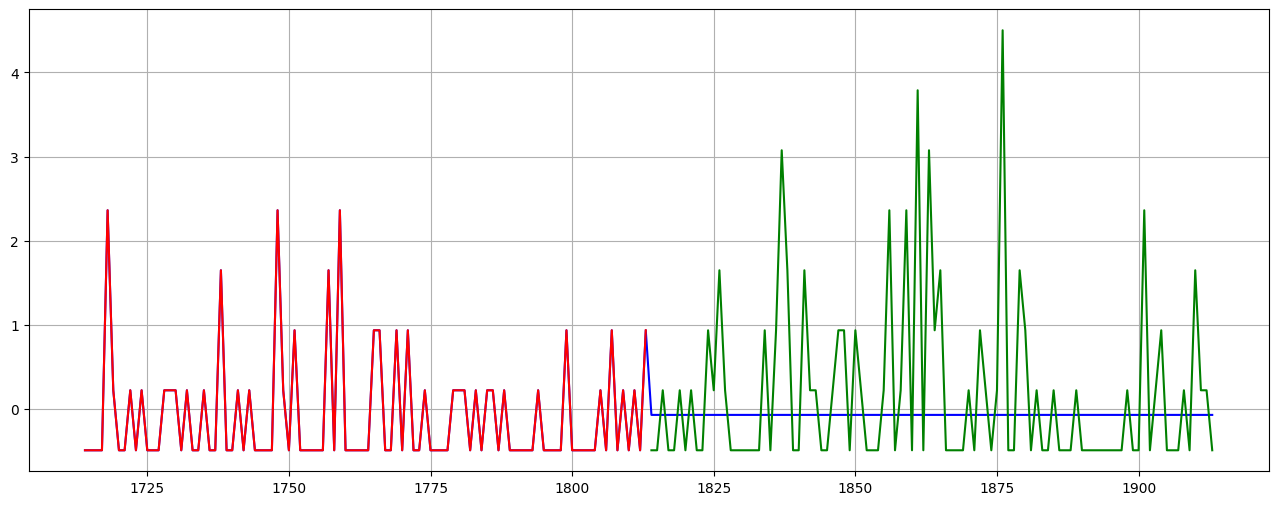

-----------------------------------------------------------------------------------------
| end of epoch   8 | time: 241.36s | valid loss 1.1354 | valid ppl     3.11
-----------------------------------------------------------------------------------------
| epoch   9 |     5/   26 batches | lr 0.000100 | 10466.95 ms | loss 1.69350 | ppl     5.44
| epoch   9 |    10/   26 batches | lr 0.000100 | 8680.15 ms | loss 1.66740 | ppl     5.30
| epoch   9 |    15/   26 batches | lr 0.000100 | 8832.01 ms | loss 1.27750 | ppl     3.59
| epoch   9 |    20/   26 batches | lr 0.000100 | 8720.26 ms | loss 0.36284 | ppl     1.44
| epoch   9 |    25/   26 batches | lr 0.000100 | 9026.03 ms | loss 0.46212 | ppl     1.59


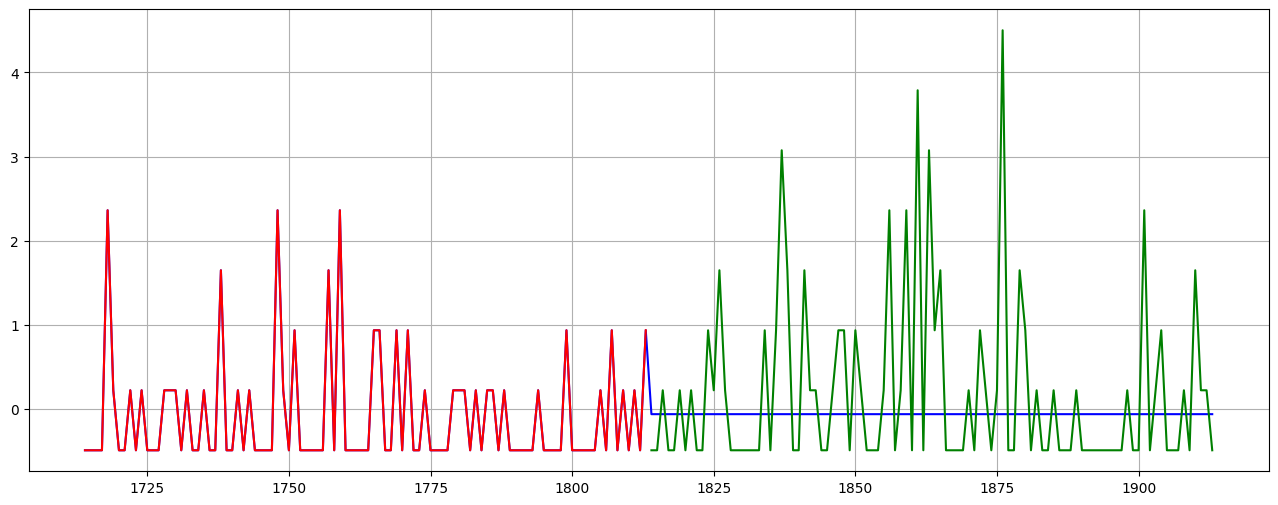

-----------------------------------------------------------------------------------------
| end of epoch   9 | time: 240.42s | valid loss 1.1307 | valid ppl     3.10
-----------------------------------------------------------------------------------------
| epoch  10 |     5/   26 batches | lr 0.000100 | 10218.63 ms | loss 1.69086 | ppl     5.42
| epoch  10 |    10/   26 batches | lr 0.000100 | 8656.24 ms | loss 1.66573 | ppl     5.29
| epoch  10 |    15/   26 batches | lr 0.000100 | 8654.90 ms | loss 1.27696 | ppl     3.59
| epoch  10 |    20/   26 batches | lr 0.000100 | 9113.69 ms | loss 0.35957 | ppl     1.43
| epoch  10 |    25/   26 batches | lr 0.000100 | 8923.95 ms | loss 0.46042 | ppl     1.58


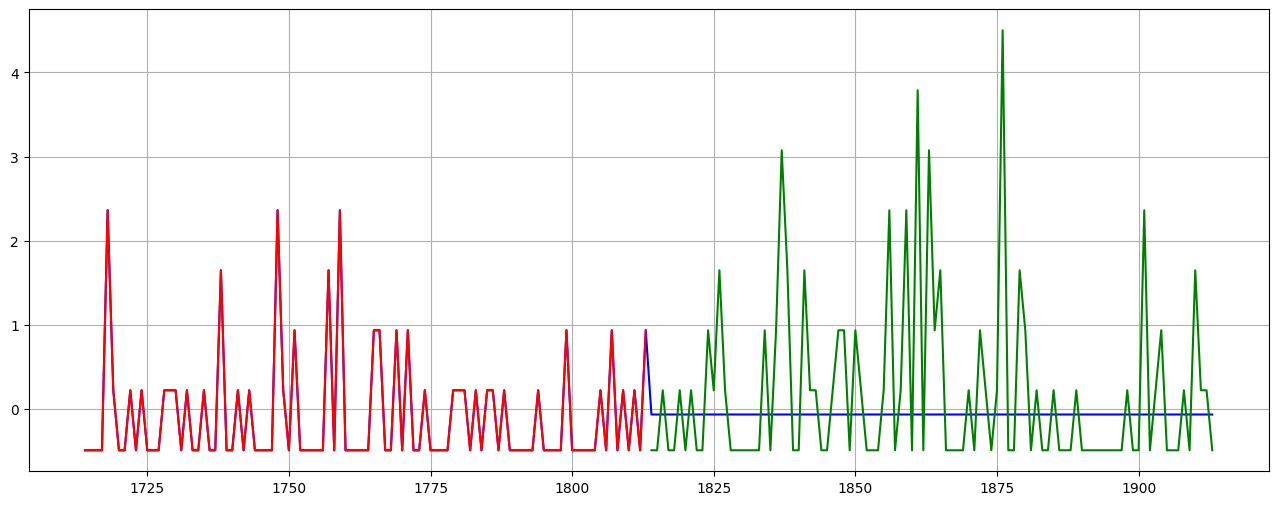

-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 239.00s | valid loss 1.1328 | valid ppl     3.10
-----------------------------------------------------------------------------------------


In [30]:
best_val_loss = float("inf")
batch_size = 64
epochs = 10 # The number of epochs
best_model = None
train_loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss = train(train_data)
    train_loss_list.append(train_loss)

    if ( epoch % 1 == 0 ):
        val_loss = plot_and_loss(model, val_data,epoch)
        predict_future(model, extracted_part, val_data,input_window)
    # else:
    val_loss = evaluate(model, val_data)
    val_loss_list.append(val_loss)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.4f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

Text(0, 0.5, 'Loss')

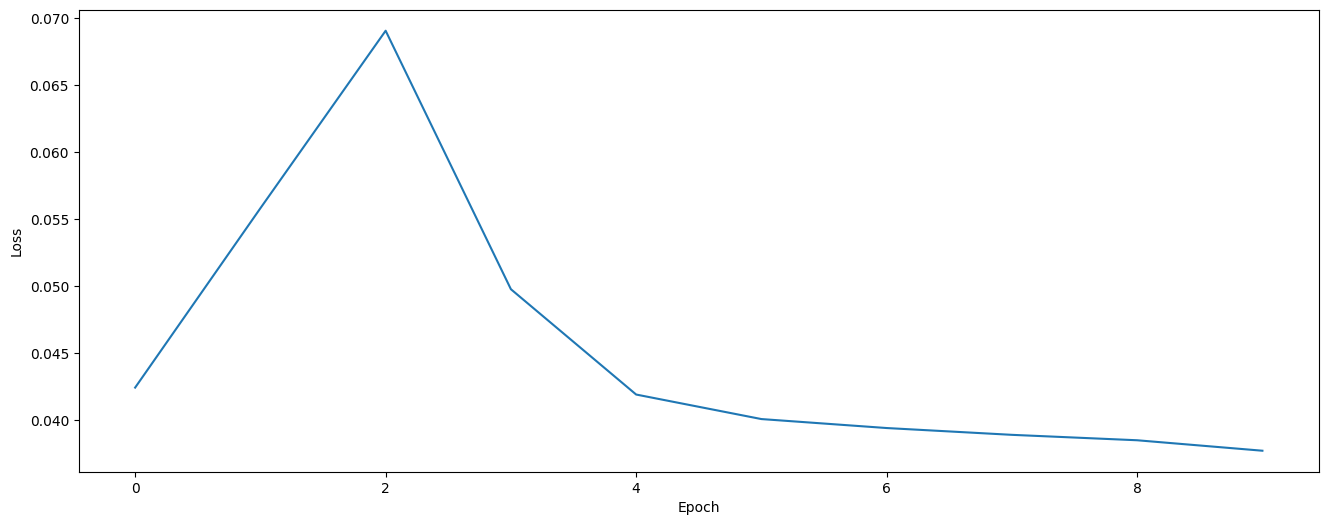

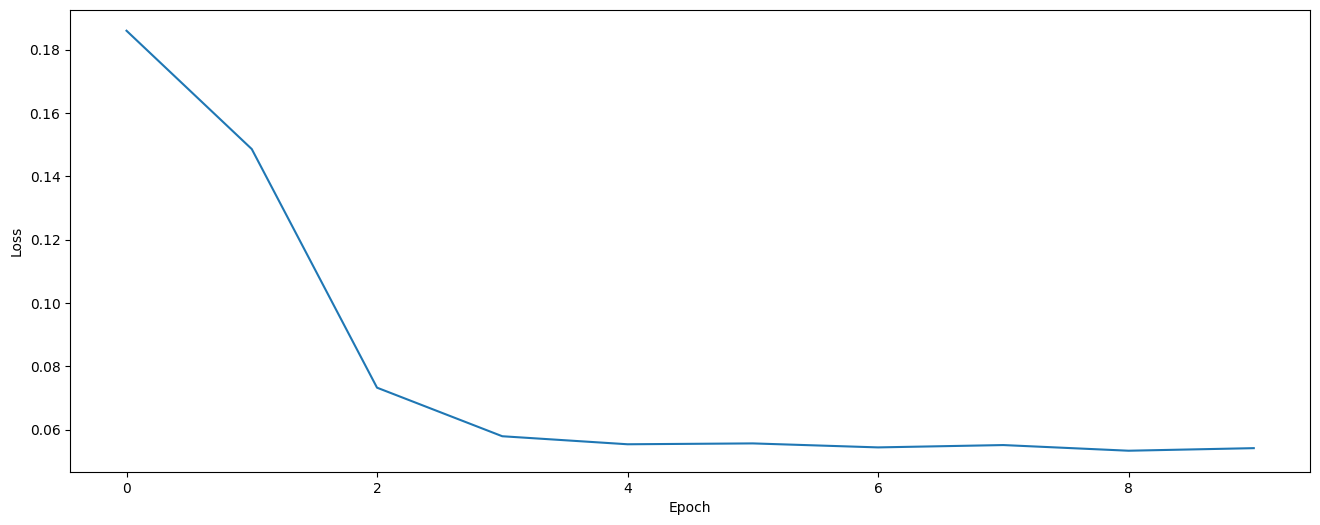

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(np.log10(train_loss_list), label='Training Loss')
# plt.plot(np.arange(10), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(16, 6))
# plt.plot(np.arange(10), train_loss_list, label='Training Loss')
plt.plot(np.log10(val_loss_list), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

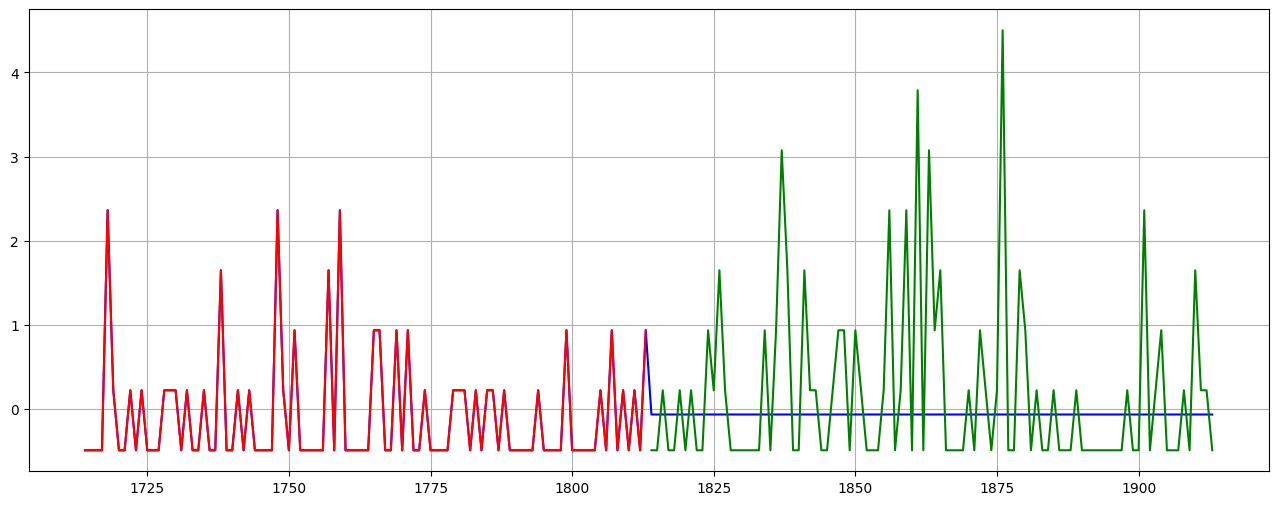

In [32]:
predict_future(model, extracted_part, val_data, input_window)

# Transformer classifier version

In [33]:
import torch
import torch.nn as nn

class TransAmClassifier(nn.Module):
    """
    TransAmClassifier: A Transformer-based model for univariate time series classification.

    This model processes a sequence of scalar values and outputs a sequence of class logits
    (for each time step) over a fixed set of discrete values.

    Architecture:
    -------------
    - Scalar inputs are linearly projected to a high-dimensional embedding space.
    - Sinusoidal positional encoding adds temporal structure.
    - Transformer encoder layers apply self-attention across the sequence.
    - A linear decoder maps each encoded position to class logits.

    Parameters
    ----------
    feature_size : int
        Dimensionality of the embedding space and the Transformer model.
    num_classes : int
        Number of distinct class labels in the output.
    num_layers : int, default=1
        Number of TransformerEncoderLayers in the encoder stack.
    dropout : float, default=0.1
        Dropout rate applied in the encoder layers.

    Input
    -----
    src : torch.Tensor of shape (input_window, batch_size, 1)
        A batch of input sequences with scalar values per timestep.

    Output
    ------
    torch.Tensor of shape (input_window, batch_size, num_classes)
        The class logits for each timestep in the input window.
    """

    def __init__(self, feature_size, num_classes, num_layers=1, dropout=0.1):
        super(TransAmClassifier, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding = nn.Linear(1, feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, num_classes)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src: (input_window, batch_size, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            self.src_mask = self._generate_square_subsequent_mask(len(src)).to(device)

        src = self.input_embedding(src)           # (input_window, batch_size, feature_size)
        src = self.pos_encoder(src)               # add positional encoding
        output = self.transformer_encoder(src, self.src_mask)  # (input_window, batch_size, feature_size)
        output = self.decoder(output)             # (input_window, batch_size, num_classes)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


In [36]:
def TrainClassifier(train_data):
    """
    Runs one epoch of training for the classification version of the Transformer model.

    For each batch:
    - Feeds input through the model to get class logits for each timestep.
    - Reshapes outputs and targets appropriately for CrossEntropyLoss.
    - Computes loss, backpropagates, and updates model parameters.
    - Logs loss and training statistics periodically.

    Parameters
    ----------
    train_data : list of tuples
        A list of (input_sequence, target_sequence) pairs, typically created using
        `create_inout_sequences`, where targets are integer class labels.

    Assumes the following global variables are defined:
    -----------------------------------------------
    model : nn.Module
        The Transformer classification model to be trained.
    optimizer : torch.optim.Optimizer
        The optimizer used for parameter updates.
    criterion : callable
        The loss function (should be nn.CrossEntropyLoss()).
    batch_size : int
        Number of samples in each mini-batch.
    input_window : int
        Length of input sequence for each sample (used in `get_batch`).
    epoch : int
        Current epoch number (used in logging output).
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler with `get_lr()` method.
    time : module
        Python's `time` module (for timing).
    math : module
        Python's `math` module (for computing perplexity via `math.exp()`).

    Returns
    -------
    float
        The average loss for the epoch.
    """
    model_classifier.train()
    total_loss = 0.
    start_time = time.time()
    losses = []

    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        output = model_classifier(data)
        output = output.view(-1, output.size(-1))
        # Map target values to 0..num_classes-1
        targets_flat = targets.view(-1)                   # flatten targets
        for idx, val in enumerate(unique_vals):           # ✅ FIX: encode labels
            targets_flat[targets_flat == val] = idx
        targets_idx = targets_flat.long()
        loss = criterion(output, targets_idx)             # compute loss with mapped targets
        loss.backward()
        optimizer.step()
        # scheduler.step()
        total_loss += loss.item()

        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            losses.append(total_loss / log_interval)
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

    return np.mean(losses)


In [37]:
def plot_and_loss_classifier(eval_model, data_source, epoch):
    """
    Evaluates the classification model on a given dataset and computes average loss.

    For each sample in the data source:
    - Performs forward pass to get class logits for each time step.
    - Computes classification loss using CrossEntropyLoss.
    - Stores predicted class labels and true labels for final step visualization.

    Parameters
    ----------
    eval_model : nn.Module
        The trained classification model to evaluate.
    data_source : list of tuples
        List of (input_sequence, target_sequence) pairs.
    epoch : int
        The current epoch number (used for logging, if needed).

    Assumes the following global variables are defined:
    -----------------------------------------------
    criterion : callable
        The loss function (nn.CrossEntropyLoss).

    Returns
    -------
    float
        The average loss over the evaluation set.
    """
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    with torch.no_grad():
        for i in range(len(data_source)):
            data, targets = get_batch(val_data, i, batch_size=1)
            output = model_classifier(data)
            output = output.view(-1, output.size(-1))
            targets_flat = targets.view(-1)
            for idx, val in enumerate(unique_vals):           # ✅ ensure validation labels are encoded
                targets_flat[targets_flat == val] = idx
            targets_idx = targets_flat.long()
            total_loss += criterion(output, targets_idx).item()

            pred_classes = output.argmax(dim=-1).cpu()   # (input_window,)
            test_result = torch.cat((test_result, pred_classes), 0)
            truth = torch.cat((truth, targets.cpu()), 0)

    return total_loss / len(data_source)


In [38]:
def evaluate_classifier(eval_model, data_source):
    """
    Evaluates the classification Transformer model on a given dataset and returns the average loss.

    Parameters
    ----------
    eval_model : nn.Module
        The trained classification model.
    data_source : list of tuples
        List of (input_sequence, target_sequence) pairs.

    Assumes the following global variables are defined:
    -----------------------------------------------
    criterion : callable
        The loss function (nn.CrossEntropyLoss).

    Returns
    -------
    float
        The average classification loss over the evaluation dataset.
    """
    eval_model.eval()
    total_loss = 0.
    eval_batch_size = 1

    with torch.no_grad():
        for i in range(0, len(data_source), eval_batch_size):
            data, targets = get_batch(val_data, i, batch_size=1)
            output = model_classifier(data)
            output = output.view(-1, output.size(-1))
            targets_flat = targets.view(-1)
            for idx, val in enumerate(unique_vals):           # ✅ ensure validation labels are encoded
                targets_flat[targets_flat == val] = idx
            targets_idx = targets_flat.long()
            total_loss += criterion(output, targets_idx).item()

    return total_loss / len(data_source)


In [47]:
def predict_future_classifier(eval_model, data_source, true_data, steps, unique_vals):
    """
    Predicts future values using the classification Transformer model in an autoregressive manner
    and plots the forecasted sequence against the true future values.

    Parameters
    ----------
    eval_model : nn.Module
        The trained classification model.
    data_source : list of tuples
        Initial data for generating the forecast. Only the first sequence is used.
    true_data : list of tuples
        The ground truth future data. Only the first sequence is used.
    steps : int
        Number of future time steps to predict.
    unique_vals : np.ndarray
        Array of unique values in the time series (used to decode predicted class index).

    Returns
    -------
    None
        Displays a plot comparing predicted and true values.
    """
    eval_model.eval()

    data, _ = get_batch(data_source, 0, 1)      # (input_window, 1, 1)
    true_data, _ = get_batch(true_data, 0, 1)   # (input_window, 1)

    with torch.no_grad():
        for i in range(steps):
            output = eval_model(data[-input_window:])  # (input_window, 1, num_classes)
            logits = output[-1]                        # (1, num_classes)
            pred_class = torch.argmax(logits, dim=-1)  # () scalar tensor
            pred_value = torch.tensor([[unique_vals[pred_class.item()]]], device=data.device, dtype=torch.float32)  # (1,1)

            # Append predicted value to sequence
            data = torch.cat((data, pred_value.unsqueeze(0)), dim=0)  # shape: (input_window + i + 1, 1, 1)

    data = data.cpu().view(-1)         # (input_window + steps,)
    true_data = true_data.cpu().view(-1)

    plt.figure(figsize=(16, 6))
    plt.plot(range(1914 - input_window - steps, 1914), data, color="blue", label='Forecast')
    plt.plot(range(1914 - input_window - steps, 1914 - steps), data[:input_window], color="red", label='Training data')
    plt.plot(range(1914 - steps, 1914), unique_vals[true_data[-steps:].long()], color="green", label='True data')
    plt.grid(True, which='both')
    plt.xlabel("Day")
    plt.ylabel("Units sold(standardized)")
    plt.title("Sales forecast")
    plt.legend()
    plt.show()
    plt.close()


In [48]:
num_classes = len(unique_vals)
num_classes = len(unique_vals)  # must be defined earlier
feature_size = 500              # or any value you want

model_classifier = TransAmClassifier(feature_size=feature_size, num_layers=3, num_classes=num_classes).to(device)



In [51]:
criterion = nn.CrossEntropyLoss()
lr = 0.0001
optimizer = torch.optim.AdamW(model_classifier.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)


| epoch   1 |     5/   26 batches | lr 0.000100 | 13599.85 ms | loss 4.84985 | ppl   127.72
| epoch   1 |    10/   26 batches | lr 0.000100 | 10612.57 ms | loss 4.93396 | ppl   138.93
| epoch   1 |    15/   26 batches | lr 0.000100 | 10706.84 ms | loss 4.34060 | ppl    76.75
| epoch   1 |    20/   26 batches | lr 0.000100 | 10750.18 ms | loss 2.53347 | ppl    12.60
| epoch   1 |    25/   26 batches | lr 0.000100 | 10245.49 ms | loss 2.36747 | ppl    10.67


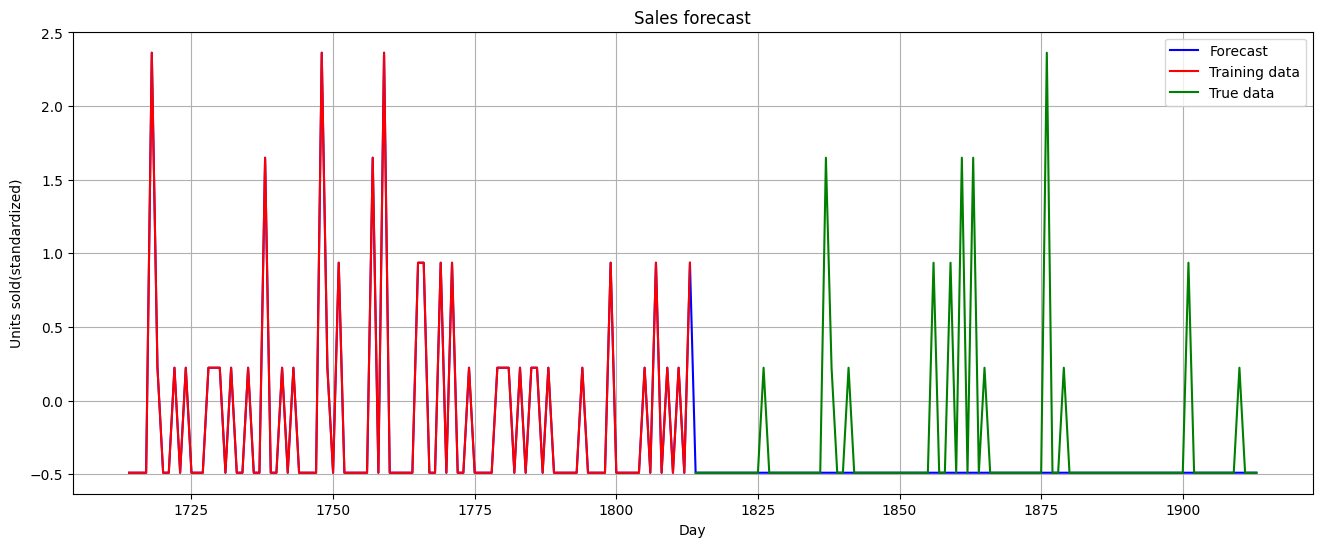

>>> Best model updated and saved (epoch 1)
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 291.65s | valid loss 5.9580 | valid ppl   386.83
-----------------------------------------------------------------------------------------
| epoch   2 |     5/   26 batches | lr 0.000100 | 13130.93 ms | loss 4.99326 | ppl   147.42
| epoch   2 |    10/   26 batches | lr 0.000100 | 10796.97 ms | loss 4.80769 | ppl   122.45
| epoch   2 |    15/   26 batches | lr 0.000100 | 10402.01 ms | loss 4.03508 | ppl    56.55
| epoch   2 |    20/   26 batches | lr 0.000100 | 10641.47 ms | loss 2.22906 | ppl     9.29
| epoch   2 |    25/   26 batches | lr 0.000100 | 10913.22 ms | loss 1.98773 | ppl     7.30


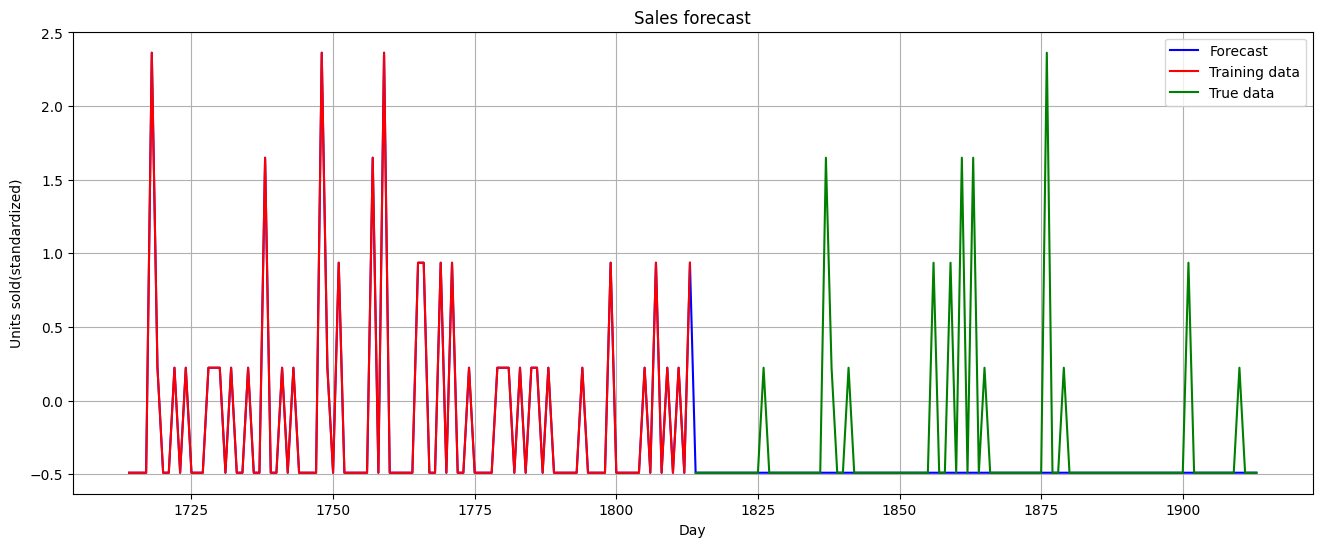

>>> Best model updated and saved (epoch 2)
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 292.17s | valid loss 4.8169 | valid ppl   123.58
-----------------------------------------------------------------------------------------
| epoch   3 |     5/   26 batches | lr 0.000100 | 13122.86 ms | loss 3.97366 | ppl    53.18
| epoch   3 |    10/   26 batches | lr 0.000100 | 10862.06 ms | loss 3.63066 | ppl    37.74
| epoch   3 |    15/   26 batches | lr 0.000100 | 10956.79 ms | loss 2.94198 | ppl    18.95
| epoch   3 |    20/   26 batches | lr 0.000100 | 11073.96 ms | loss 1.52859 | ppl     4.61
| epoch   3 |    25/   26 batches | lr 0.000100 | 10492.69 ms | loss 1.34939 | ppl     3.86


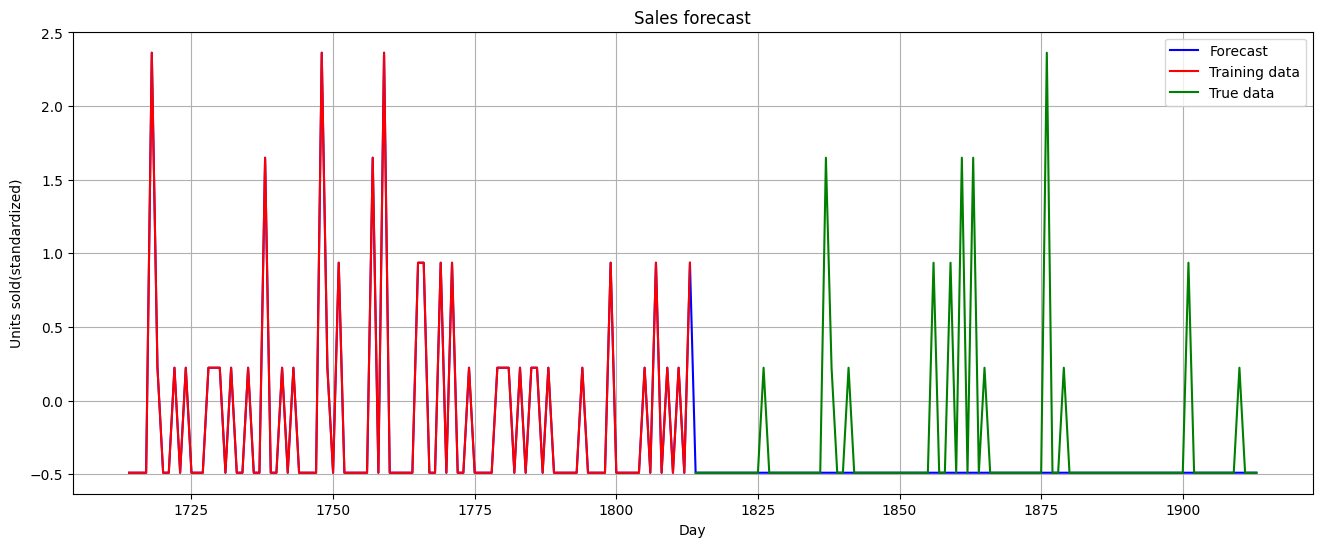

>>> Best model updated and saved (epoch 3)
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 294.78s | valid loss 3.0218 | valid ppl    20.53
-----------------------------------------------------------------------------------------
| epoch   4 |     5/   26 batches | lr 0.000100 | 13471.94 ms | loss 2.57229 | ppl    13.10
| epoch   4 |    10/   26 batches | lr 0.000100 | 10771.19 ms | loss 2.26787 | ppl     9.66
| epoch   4 |    15/   26 batches | lr 0.000100 | 10259.57 ms | loss 1.93096 | ppl     6.90
| epoch   4 |    20/   26 batches | lr 0.000100 | 11308.88 ms | loss 1.26570 | ppl     3.55
| epoch   4 |    25/   26 batches | lr 0.000100 | 11066.72 ms | loss 1.42950 | ppl     4.18


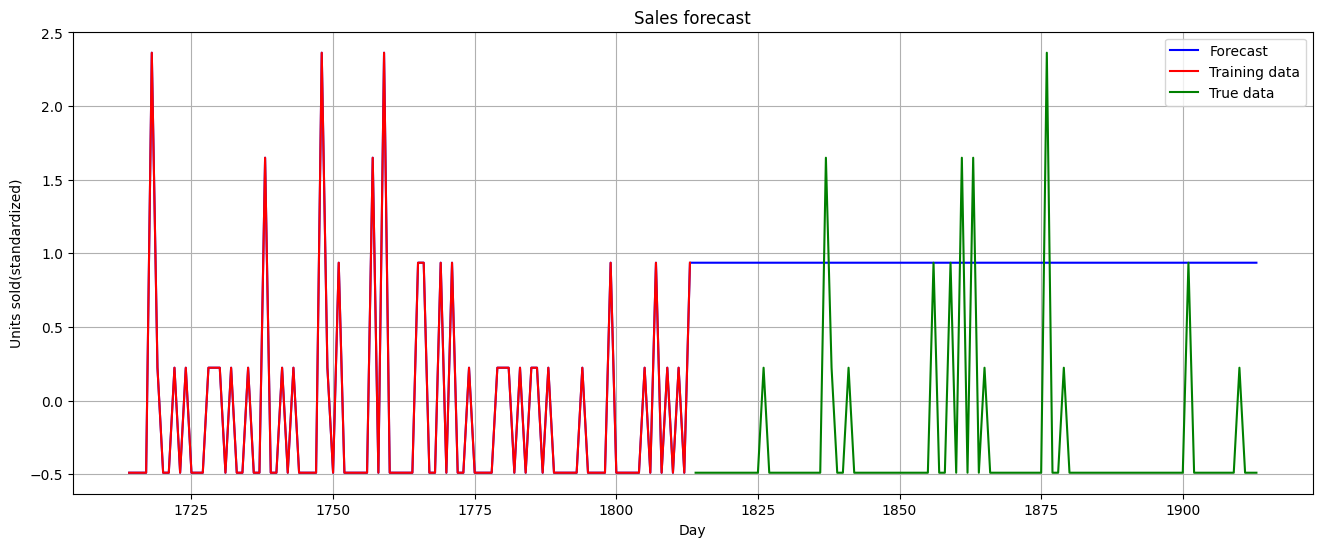

>>> Best model updated and saved (epoch 4)
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 297.43s | valid loss 2.1411 | valid ppl     8.51
-----------------------------------------------------------------------------------------
| epoch   5 |     5/   26 batches | lr 0.000100 | 13226.35 ms | loss 2.38511 | ppl    10.86
| epoch   5 |    10/   26 batches | lr 0.000100 | 11033.91 ms | loss 2.01408 | ppl     7.49


KeyboardInterrupt: 

In [52]:
best_val_loss = float("inf")
batch_size = 64
epochs = 20  # Number of epochs
best_model = None
train_loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    train_loss = TrainClassifier(train_data)
    train_loss_list.append(train_loss)

    if (epoch % 1 == 0):
        val_loss = plot_and_loss_classifier(model_classifier, val_data, epoch)
        predict_future_classifier(model_classifier, extracted_part, val_data, input_window, unique_vals)
    else:
        val_loss = evaluate_classifier(model_classifier, val_data)
    val_loss_list.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # torch.save(model_classifier.state_dict(), '/content/model/best_model_classifier')
        print(f">>> Best model updated and saved (epoch {epoch})")

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.4f} | valid ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time),
        val_loss, math.exp(val_loss)))
    print('-' * 89)


Text(0, 0.5, 'Loss')

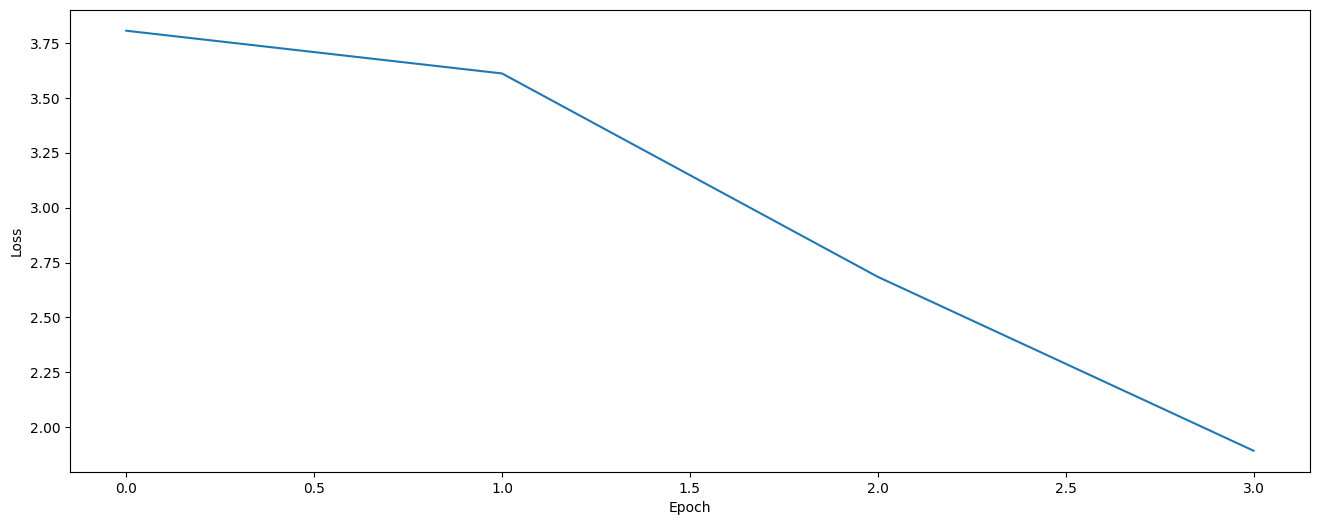

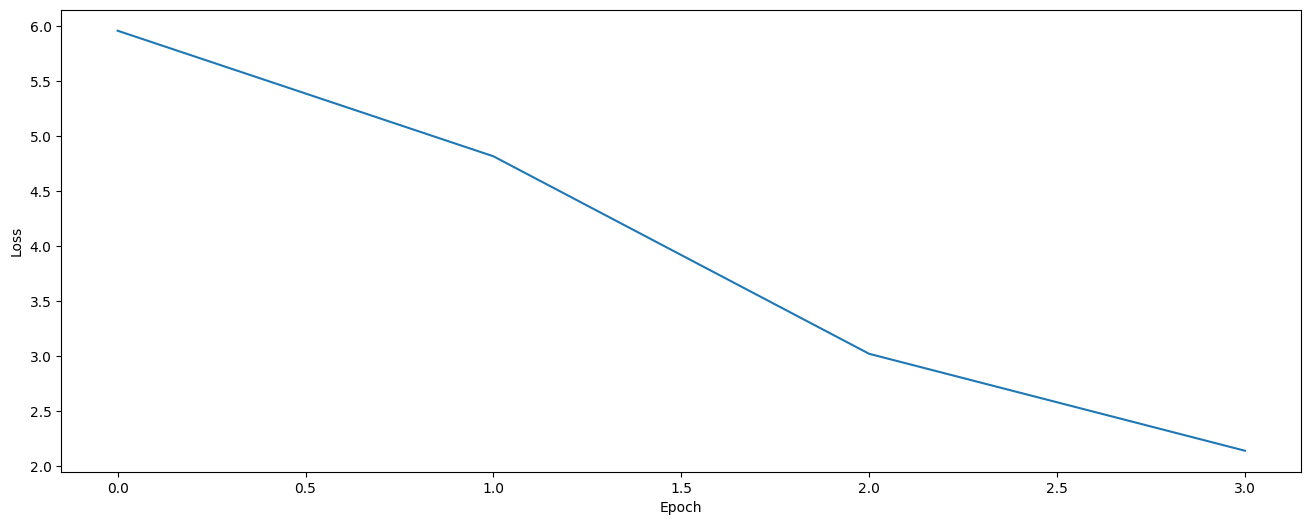

In [55]:
plt.figure(figsize=(16, 6))
plt.plot(train_loss_list, label='Training Loss')
# plt.plot(np.arange(10), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(16, 6))
# plt.plot(np.arange(10), train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

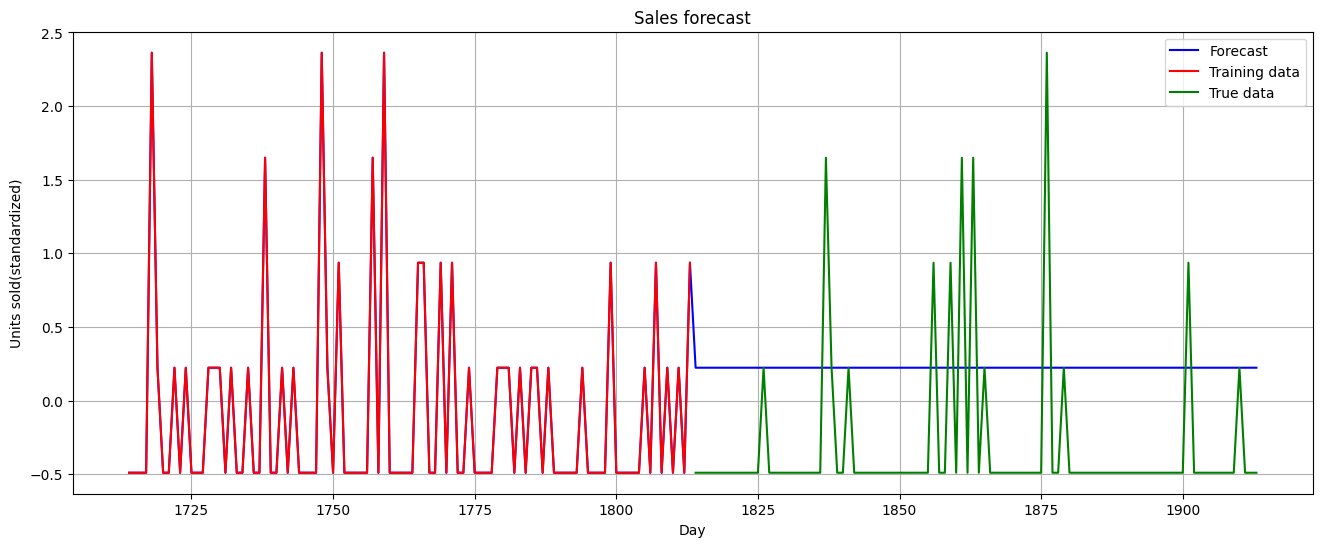

In [53]:
predict_future_classifier(model_classifier, extracted_part, val_data, input_window, unique_vals)

In [59]:
num_classes = len(unique_vals)
num_classes = len(unique_vals)  # must be defined earlier
feature_size = 500              # or any value you want

model_classifier = TransAmClassifier(feature_size=feature_size, num_layers = 3, num_classes=num_classes).to(device)

In [60]:
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
lr = 0.0005
optimizer = torch.optim.AdamW(model_classifier.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)


| epoch   1 |     5/   26 batches | lr 0.000500 | 10575.09 ms | loss 7.83869 | ppl  2536.88
| epoch   1 |    10/   26 batches | lr 0.000500 | 8642.87 ms | loss 9.44406 | ppl 12632.89
| epoch   1 |    15/   26 batches | lr 0.000500 | 8504.48 ms | loss 5.86534 | ppl   352.60
| epoch   1 |    20/   26 batches | lr 0.000500 | 8695.01 ms | loss 3.86920 | ppl    47.90
| epoch   1 |    25/   26 batches | lr 0.000500 | 8906.06 ms | loss 4.92475 | ppl   137.65


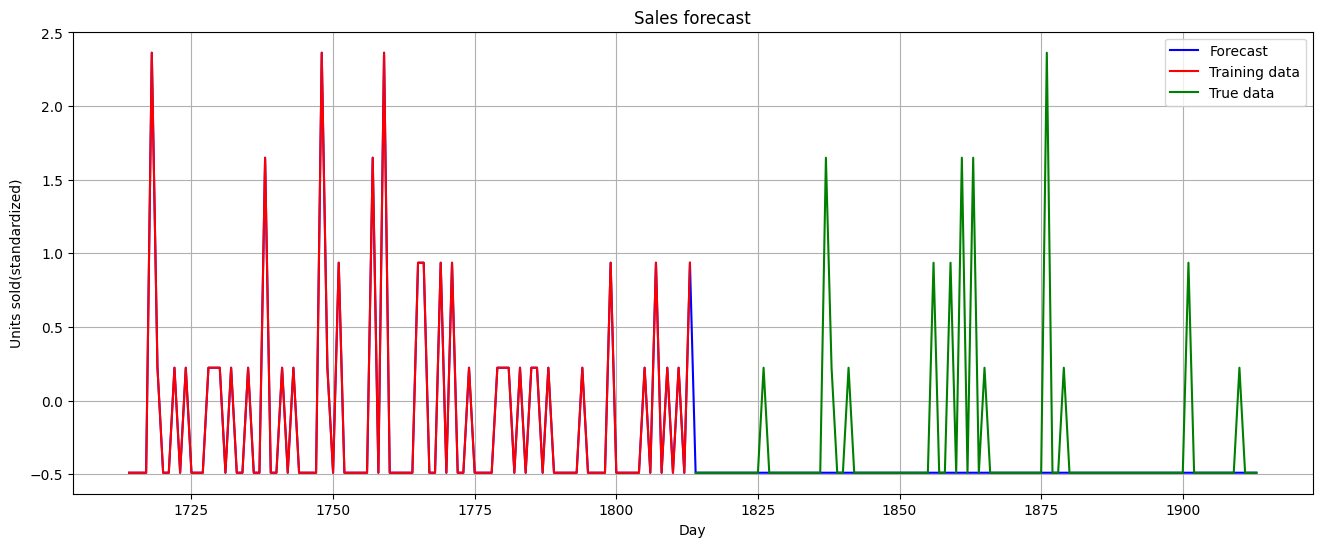

>>> Best model updated and saved (epoch 1)
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 238.20s | valid loss 7.1092 | valid ppl  1223.16
-----------------------------------------------------------------------------------------
| epoch   2 |     5/   26 batches | lr 0.000500 | 10527.97 ms | loss 8.95322 | ppl  7732.78
| epoch   2 |    10/   26 batches | lr 0.000500 | 9663.61 ms | loss 7.95781 | ppl  2857.81
| epoch   2 |    15/   26 batches | lr 0.000500 | 9764.14 ms | loss 6.18707 | ppl   486.42
| epoch   2 |    20/   26 batches | lr 0.000500 | 9311.83 ms | loss 5.77545 | ppl   322.29
| epoch   2 |    25/   26 batches | lr 0.000500 | 10558.04 ms | loss 7.62302 | ppl  2044.73


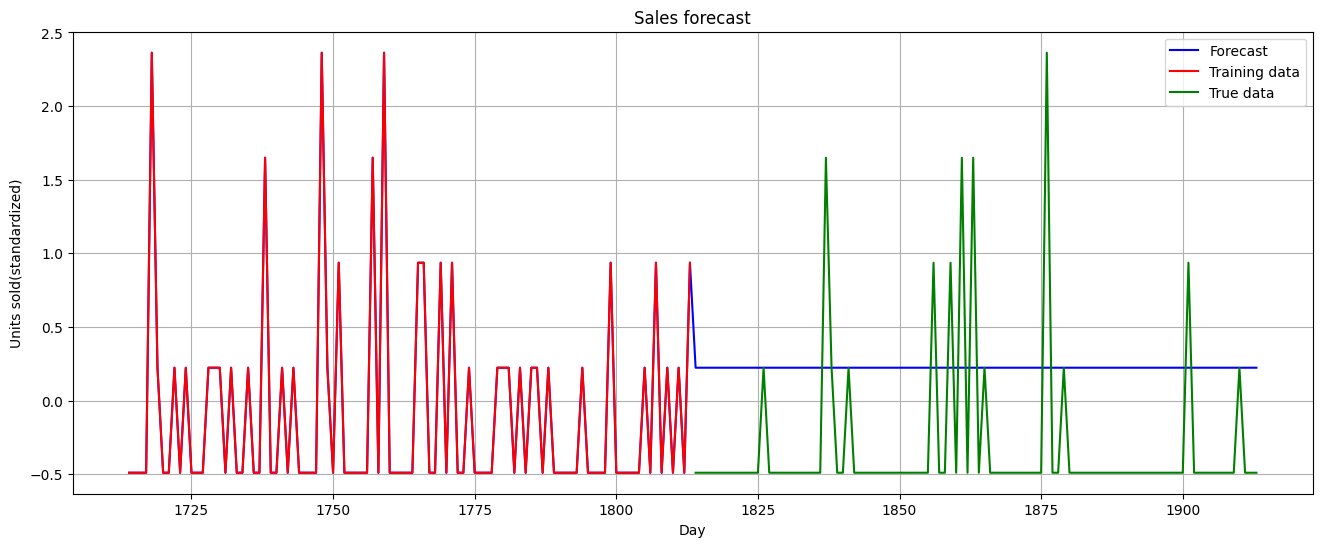

>>> Best model updated and saved (epoch 2)
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 262.72s | valid loss 6.6888 | valid ppl   803.33
-----------------------------------------------------------------------------------------
| epoch   3 |     5/   26 batches | lr 0.000500 | 13315.68 ms | loss 9.57312 | ppl 14373.22
| epoch   3 |    10/   26 batches | lr 0.000500 | 10328.51 ms | loss 8.02741 | ppl  3063.79
| epoch   3 |    15/   26 batches | lr 0.000500 | 10373.89 ms | loss 5.91986 | ppl   372.36
| epoch   3 |    20/   26 batches | lr 0.000500 | 11038.73 ms | loss 8.76402 | ppl  6399.77
| epoch   3 |    25/   26 batches | lr 0.000500 | 10424.66 ms | loss 9.37862 | ppl 11832.63


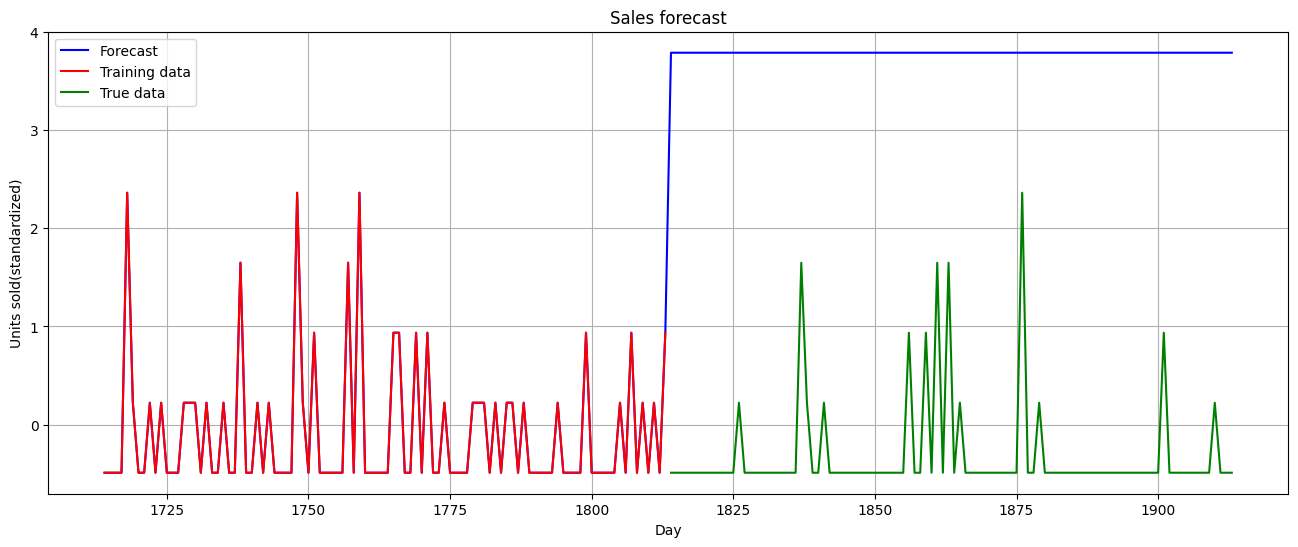

-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 289.48s | valid loss 7.9864 | valid ppl  2940.70
-----------------------------------------------------------------------------------------
| epoch   4 |     5/   26 batches | lr 0.000500 | 13607.98 ms | loss 8.18349 | ppl  3581.33
| epoch   4 |    10/   26 batches | lr 0.000500 | 12568.86 ms | loss 5.29068 | ppl   198.48
| epoch   4 |    15/   26 batches | lr 0.000500 | 12522.92 ms | loss 5.58304 | ppl   265.88
| epoch   4 |    20/   26 batches | lr 0.000500 | 12571.67 ms | loss 6.00319 | ppl   404.72
| epoch   4 |    25/   26 batches | lr 0.000500 | 14418.05 ms | loss 6.09204 | ppl   442.32


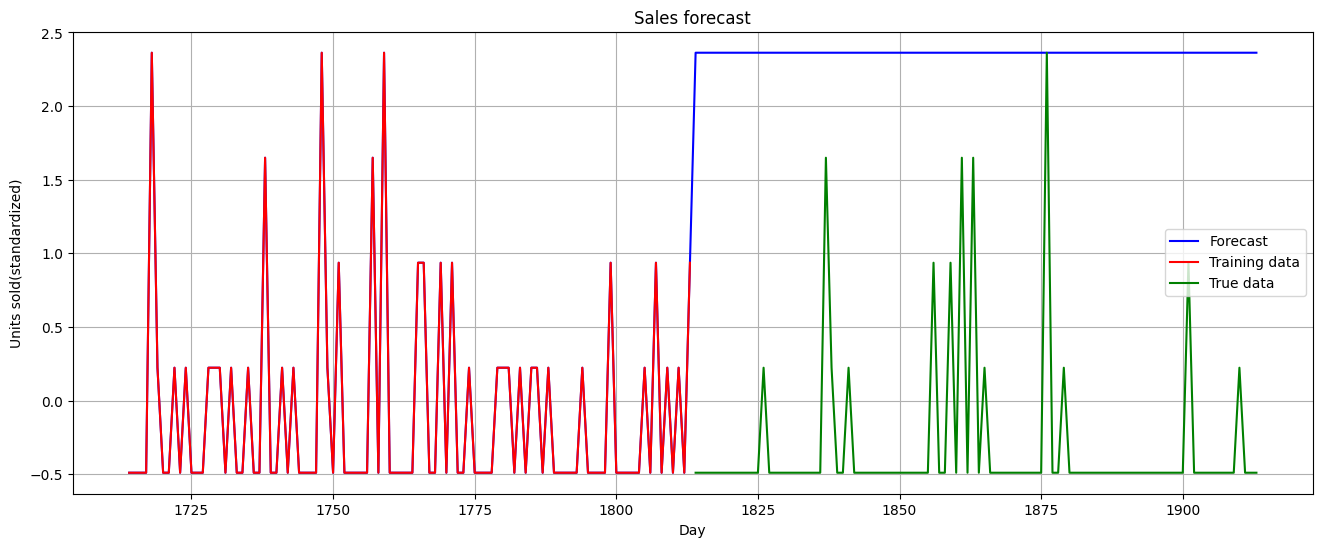

-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 345.58s | valid loss 6.8665 | valid ppl   959.54
-----------------------------------------------------------------------------------------
| epoch   5 |     5/   26 batches | lr 0.000500 | 23169.73 ms | loss 8.44165 | ppl  4636.18
| epoch   5 |    10/   26 batches | lr 0.000500 | 21257.42 ms | loss 7.40539 | ppl  1644.83
| epoch   5 |    15/   26 batches | lr 0.000500 | 21648.86 ms | loss 7.93910 | ppl  2804.84
| epoch   5 |    20/   26 batches | lr 0.000500 | 21694.95 ms | loss 4.68562 | ppl   108.38
| epoch   5 |    25/   26 batches | lr 0.000500 | 22535.70 ms | loss 4.60757 | ppl   100.24


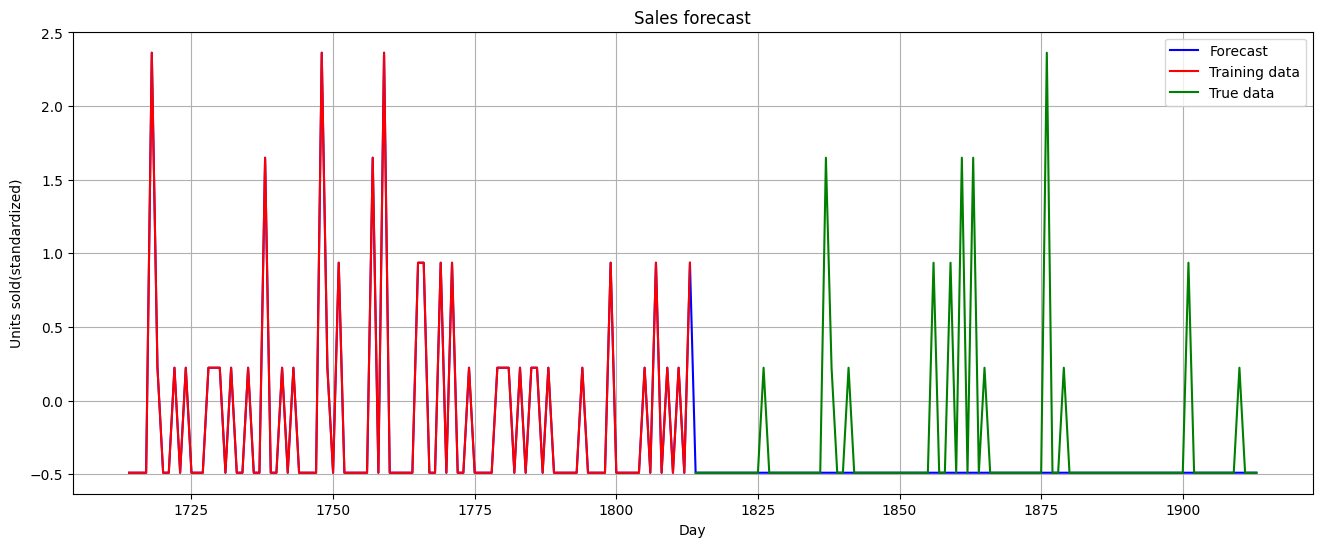

-----------------------------------------------------------------------------------------
| end of epoch   5 | time: 574.60s | valid loss 7.0325 | valid ppl  1132.84
-----------------------------------------------------------------------------------------
| epoch   6 |     5/   26 batches | lr 0.000500 | 28392.38 ms | loss 11.26992 | ppl 78426.54
| epoch   6 |    10/   26 batches | lr 0.000500 | 23936.05 ms | loss 10.75021 | ppl 46639.99
| epoch   6 |    15/   26 batches | lr 0.000500 | 24777.38 ms | loss 10.05837 | ppl 23350.41
| epoch   6 |    20/   26 batches | lr 0.000500 | 26587.95 ms | loss 4.88994 | ppl   132.95
| epoch   6 |    25/   26 batches | lr 0.000500 | 25891.63 ms | loss 5.35853 | ppl   212.41


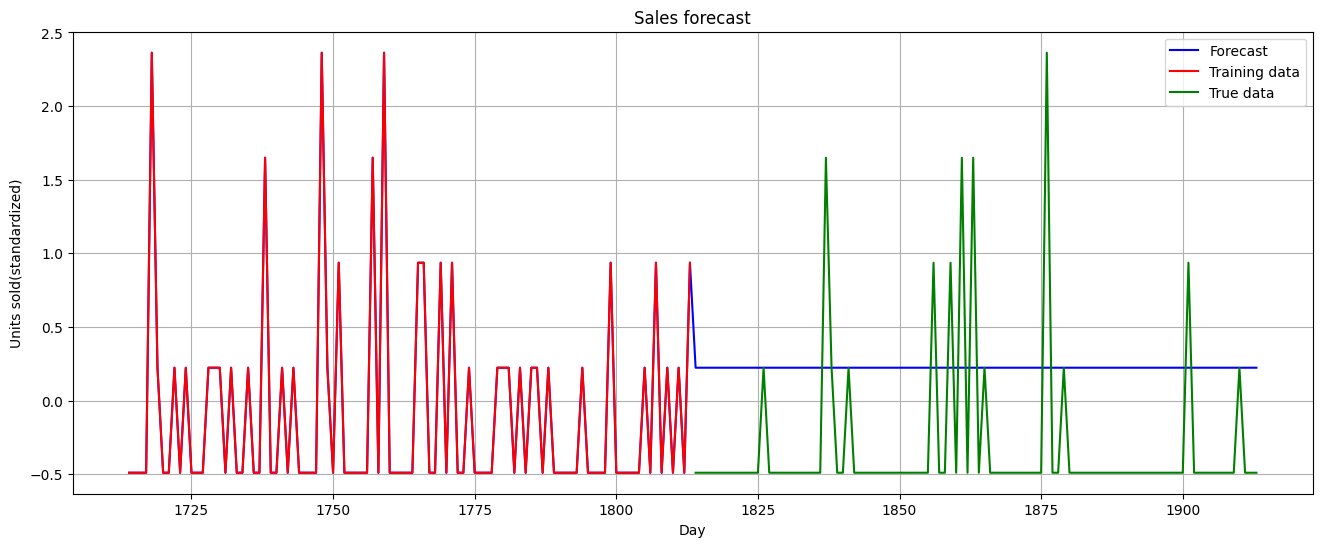

>>> Best model updated and saved (epoch 6)
-----------------------------------------------------------------------------------------
| end of epoch   6 | time: 672.24s | valid loss 6.6470 | valid ppl   770.49
-----------------------------------------------------------------------------------------
| epoch   7 |     5/   26 batches | lr 0.000500 | 29995.69 ms | loss 13.31424 | ppl 605760.85
| epoch   7 |    10/   26 batches | lr 0.000500 | 24446.65 ms | loss 13.49091 | ppl 722816.13


KeyboardInterrupt: 

In [61]:
best_val_loss = float("inf")
batch_size = 64
epochs = 20  # Number of epochs
best_model = None
train_loss_list = []
val_loss_list = []

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    train_loss = TrainClassifier(train_data)
    train_loss_list.append(train_loss)

    if (epoch % 1 == 0):
        val_loss = plot_and_loss_classifier(model_classifier, val_data, epoch)
        predict_future_classifier(model_classifier, extracted_part, val_data, input_window, unique_vals)
    else:
        val_loss = evaluate_classifier(model_classifier, val_data)
    val_loss_list.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # torch.save(model_classifier.state_dict(), '/content/model/best_model_classifier')
        print(f">>> Best model updated and saved (epoch {epoch})")

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.4f} | valid ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time),
        val_loss, math.exp(val_loss)))
    print('-' * 89)
